**RFM Analysis**

Scoring criteria is based on a year to year basis.
A “5” in recency indicate a donation in the last 20% of the year for that year.
A “5” in frequency indicates being in the top 20% of donors when measuring based solely on the number of times each donor donated in a given year.
A “5” in monetary indicates being in the top 20% of overall donation amounts for a given year.

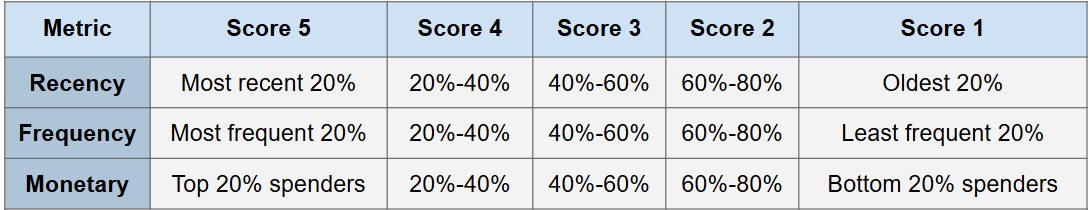

Segmentation was then conducted based off RFM scoring with “weight” considerations.
For example a 115, 151 and a  511 all show up a 7, but the value and what each donor represents are significantly different. Thus, need to be approached and segmented differently.


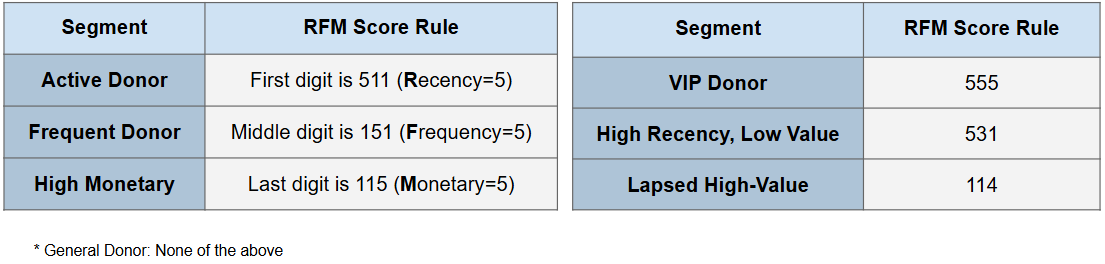

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

**Segmentation**

In [2]:
# Load Data
gift_df = pd.read_excel("/content/ASU Gift Record 20250106 ANONYMIZED.xlsx")
rfm_df = pd.read_excel("/content/RFM Score Computation.xlsx")
gift_df["Date"] = pd.to_datetime(gift_df["Date"], errors="coerce")
gift_df["Year"] = gift_df["Date"].dt.year

In [3]:
# Prepare Aggregated Data Across 2020–2024
all_data = []
for year in range(2020, 2025):
    snapshot = pd.to_datetime(f"{year}-12-31")
    gift_y = gift_df[gift_df["Year"] == year]
    agg = gift_y.groupby("ConstituentLookupId").agg({
        "Date": lambda x: (snapshot - x.max()).days,
        "Amount": "sum"
    }).reset_index()
    agg.columns = ["ConstituentLookupId", "Recency_days", "Total_Donation"]
    agg["Year"] = year
    agg.rename(columns={"ConstituentLookupId": "Donor ID"}, inplace=True)
    rfm_y = rfm_df[rfm_df["Year"] == year][["Donor ID", "Segment"]]
    merged = pd.merge(agg, rfm_y, on="Donor ID", how="left").dropna()
    all_data.append(merged)
df_all = pd.concat(all_data, ignore_index=True)

In [4]:
df_all.head()

,Donor ID,Recency_days,Total_Donation,Year,Segment
0,111,236,10.50,2020,General Donor
1,859,349,200.00,2020,General Donor
2,864,76,49.27,2020,General Donor
3,899,209,120.00,2020,Frequent Donor
4,907,125,31.42,2020,General Donor


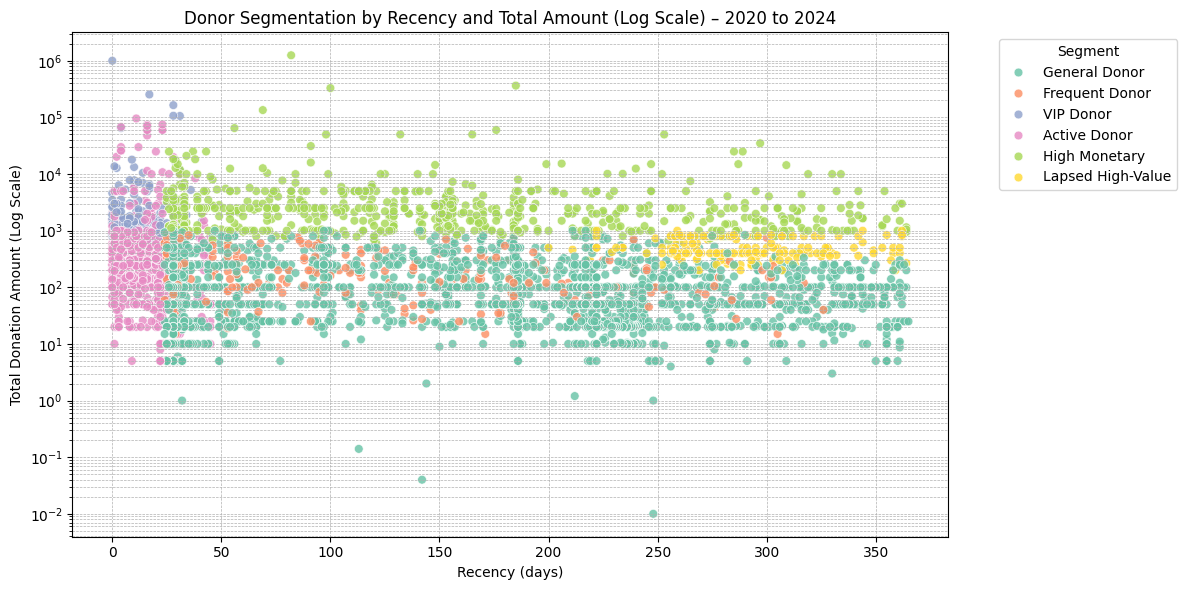

In [5]:
# Plot Combined Segmentation Scatter
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_all,
    x="Recency_days",
    y="Total_Donation",
    hue="Segment",
    palette="Set2",
    alpha=0.8,
    s=40
)
plt.yscale("log")
plt.title("Donor Segmentation by Recency and Total Amount (Log Scale) – 2020 to 2024")
plt.xlabel("Recency (days)")
plt.ylabel("Total Donation Amount (Log Scale)")
plt.legend(title="Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

**Donor / Donation Trends**

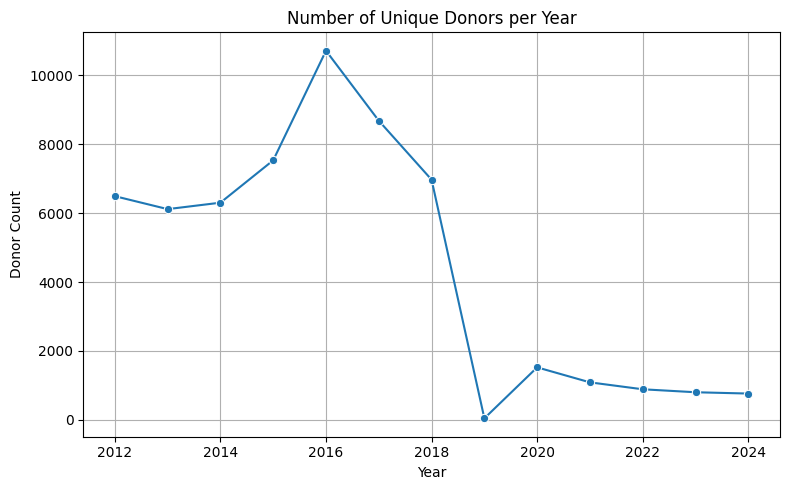

In [6]:
# Number of Unique Donors over Year
donor_count_per_year = gift_df.groupby("Year")["ConstituentLookupId"].nunique().reset_index()
donor_count_per_year.columns = ["Year", "Unique_Donors"]

plt.figure(figsize=(8, 5))
sns.lineplot(data=donor_count_per_year, x="Year", y="Unique_Donors", marker="o")
plt.title("Number of Unique Donors per Year")
plt.ylabel("Donor Count")
plt.grid(True)
plt.tight_layout()
plt.show()

- Significant Decline Since 2016: After peaking in 2016 with over 10,000 unique donors, there's a sharp decline from 2019 onward.

- Post-2020: From 2020 to 2024, the donor count stabilized at a much lower level, below 1,000 donors per year.

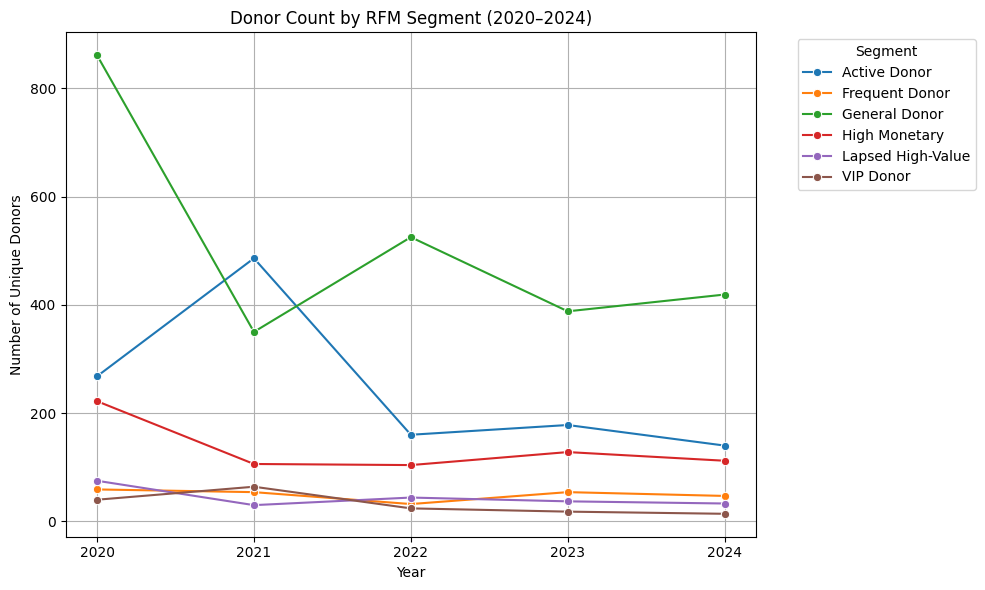

In [7]:
rfm_yearly = rfm_df[["Donor ID", "Year", "Segment"]].dropna()
# Number of donor in each segment
rfm_seg_trend = rfm_yearly.groupby(["Year", "Segment"])["Donor ID"].nunique().reset_index()
rfm_seg_trend.columns = ["Year", "Segment", "Donor_Count"]

plt.figure(figsize=(10, 6))
sns.lineplot(data=rfm_seg_trend, x="Year", y="Donor_Count", hue="Segment", marker="o")
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.title("Donor Count by RFM Segment (2020–2024)")
plt.xlabel("Year")
plt.ylabel("Number of Unique Donors")
plt.legend(title="Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

- Dominated by “General Donor” and “Active Donor”: These segments make up the bulk of yearly donors.

- “High Monetary” and “VIP Donor” Segments Are Very Small: Indicating relatively few high-value contributors.

- Segments Remain Stable: RFM segments don't fluctuate drastically year to year, suggesting consistent behavior among retained donors.

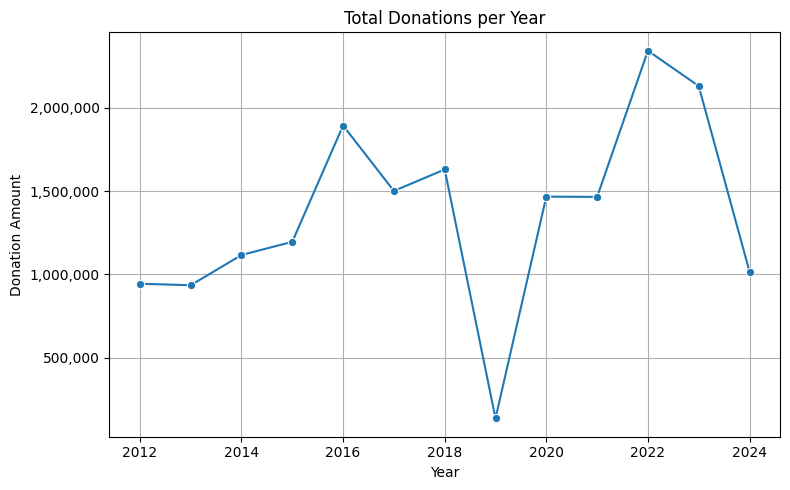

In [8]:
# Total Donations per Year
donation_sum_per_year = gift_df.groupby("Year")["Amount"].sum().reset_index()
donation_sum_per_year.columns = ["Year", "Total_Donation"]

plt.figure(figsize=(8, 5))
sns.lineplot(data=donation_sum_per_year, x="Year", y="Total_Donation", marker="o")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.title("Total Donations per Year")
plt.ylabel("Donation Amount")
plt.grid(True)
plt.tight_layout()
plt.show()

This suggests donor base fatigue, attrition, or insufficient acquisition of new donors.

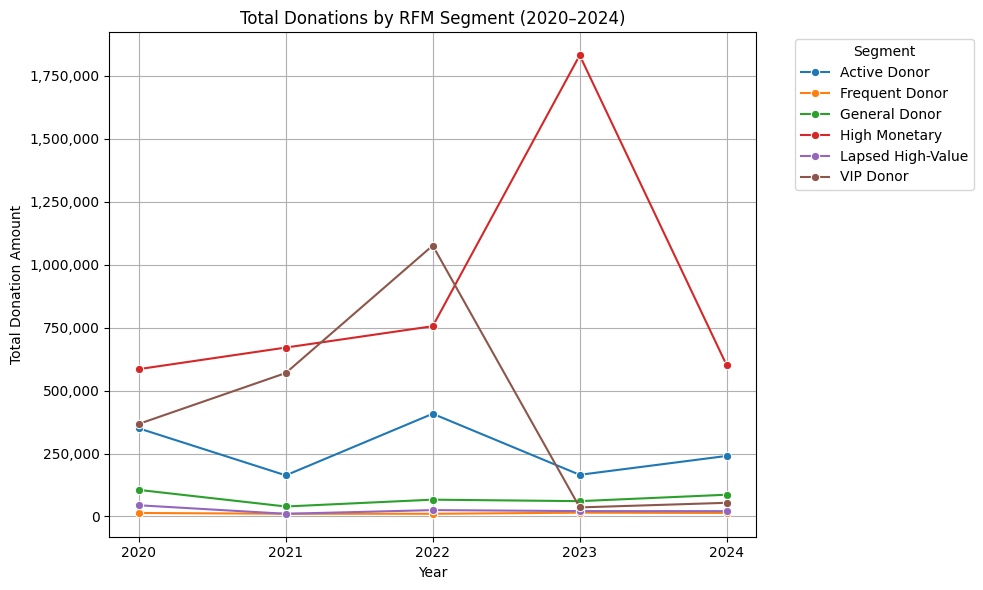

In [12]:
gift_with_rfm = pd.merge(gift_df, rfm_df[['Donor ID', 'Year', 'Segment']], left_on=['ConstituentLookupId', 'Year'], right_on=['Donor ID', 'Year'], how='left') # Changed 'DonorID' to 'ConstituentLookupId'

# Drop records without segment info
gift_with_rfm = gift_with_rfm.dropna(subset=["Segment"])
# Aggregate total donation by year and segment
donation_seg_year = gift_with_rfm.groupby(["Year", "Segment"])["Amount"].sum().reset_index()
donation_seg_year.columns = ["Year", "Segment", "Total_Donation"]

# Plot total donation by RFM segment over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=donation_seg_year, x="Year", y="Total_Donation", hue="Segment", marker="o")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.title("Total Donations by RFM Segment (2020–2024)")
plt.xlabel("Year")
plt.ylabel("Total Donation Amount")
plt.legend(title="Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

- "General Donor" remains the largest group but fluctuates significantly.

- "VIP Donor" and "High Monetary" segments are small but consistently present.

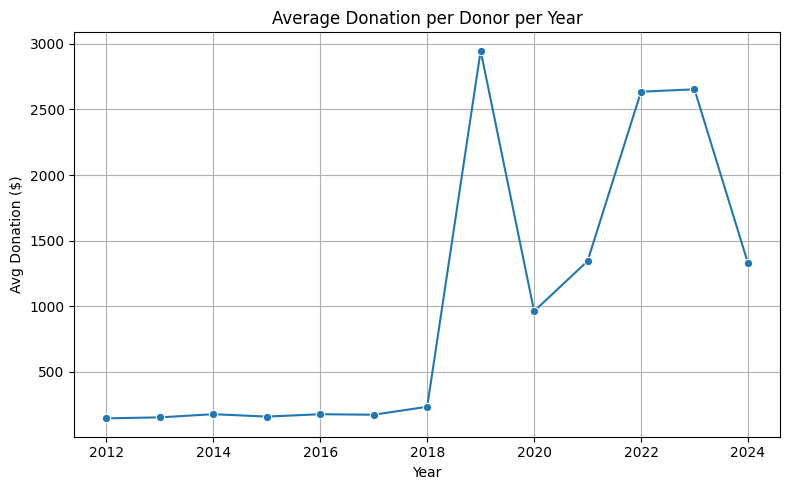

In [22]:
# Average Donation per Donor per year
avg_donation_per_year = (donation_sum_per_year["Total_Donation"] / donor_count_per_year["Unique_Donors"]).reset_index(drop=True)
donation_sum_per_year["Avg_Donation_per_Donor"] = avg_donation_per_year

plt.figure(figsize=(8, 5))
sns.lineplot(data=donation_sum_per_year, x="Year", y="Avg_Donation_per_Donor", marker="o")
plt.title("Average Donation per Donor per Year")
plt.ylabel("Avg Donation ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Strategic Profiling of High-Value Donors**

In [15]:
# Filter for 2023–2024 Donations Only
recent_gift = gift_df[gift_df["Year"].isin([2023, 2024])]

# Identify Top Donors by Total Giving in 2023–2024
top_donors = (
    recent_gift.groupby("ConstituentLookupId")["Amount"]
    .sum()
    .nlargest(15)
    .index)

# Pull Full Donation Records (2020–2024) for These Donors
top_gift_df = gift_df[
    (gift_df["ConstituentLookupId"].isin(top_donors)) &
    (gift_df["Year"].between(2020, 2024))]

In [16]:
# Pivot to Create Yearly Donation Table
donation_pivot = top_gift_df.pivot_table(
    index="ConstituentLookupId",
    columns="Year",
    values="Amount",
    aggfunc="sum",
    fill_value=0
).reset_index()

In [17]:
# Classify Donors Based on 2022–2024 Behavior
def classify_behavior(row):
    d2022 = row.get(2022, 0)
    d2023 = row.get(2023, 0)
    d2024 = row.get(2024, 0)
    if d2022 > 0 and d2023 > d2022 and d2024 > d2023:
        return "Consistent Grower"
    elif (d2022 == 0 or d2023 == 0) and d2024 > 0:
        return "Returning Donor"
    elif d2023 > 0 and d2024 == 0:
        return "Lapsed Donor"
    elif d2022 > 0 and d2023 > 0 and d2024 < d2023:
        return "Declining Supporter"
    else:
        return "Other"
donation_pivot["Category"] = donation_pivot.apply(classify_behavior, axis=1)

In [18]:
# Map Strategy by Category
strategy_map = {
    "Consistent Grower": "Offer long-term engagement, naming opportunities, exclusive recognition",
    "Returning Donor": "Understand what brought them back, initiate personalized re-engagement",
    "Declining Supporter": "Send 'We miss you' notes and feedback surveys",
    "Lapsed Donor": "Reinitiate contact and assess interest",
    "Other": "Review manually"
}
donation_pivot["Suggested Strategy"] = donation_pivot["Category"].map(strategy_map)

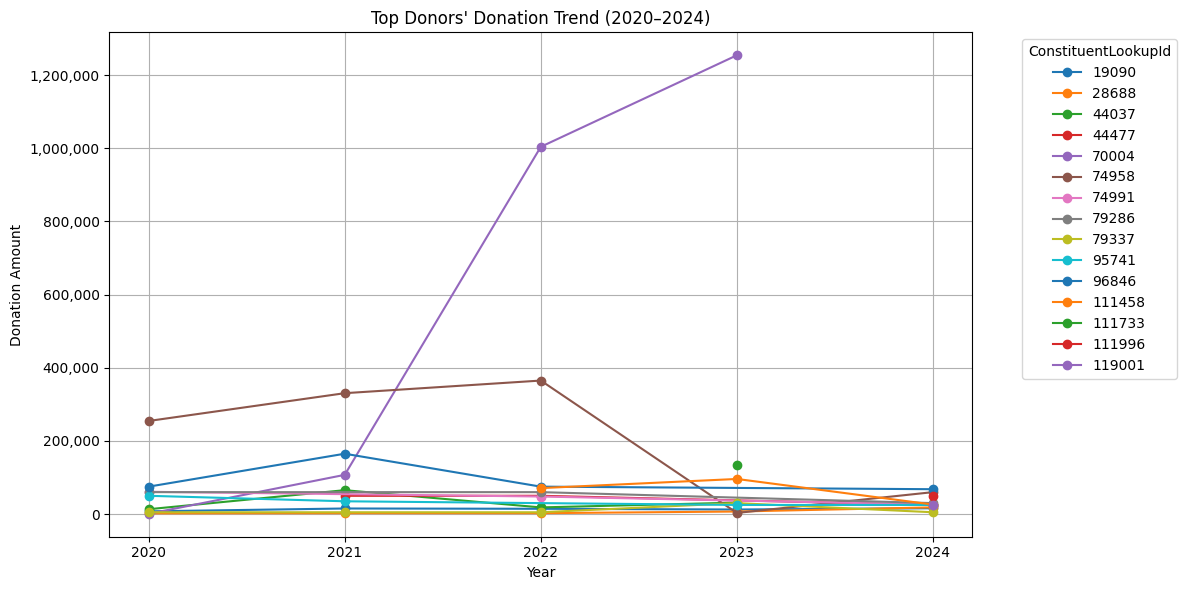

In [19]:
# Plot Trend from 2020–2024
trend_data = top_gift_df.groupby(["ConstituentLookupId", "Year"])["Amount"].sum().reset_index()

plt.figure(figsize=(12, 6))
for donor_id in trend_data["ConstituentLookupId"].unique():
    subset = trend_data[trend_data["ConstituentLookupId"] == donor_id]
    plt.plot(subset["Year"], subset["Amount"], marker='o', label=str(donor_id))

plt.title("Top Donors' Donation Trend (2020–2024)")
plt.xlabel("Year")
plt.ylabel("Donation Amount")
plt.grid(True)
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title="ConstituentLookupId", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(ticks=range(2020, 2025))
plt.tight_layout()
plt.show()

In [20]:
# Summary Table for Strategic Profiling
profile_summary = donation_pivot[["ConstituentLookupId", 2022, 2023, 2024, "Category", "Suggested Strategy"]]

# Format Donations with Commas
profile_summary_formatted = profile_summary.copy()
for year in [2022, 2023, 2024]:
    profile_summary_formatted[year] = profile_summary_formatted[year].apply(lambda x: f"${x:,.0f}")

# Display Formatted Table
print("\nStrategic Donor Profiling Summary:")
profile_summary_formatted.sort_values("Category")


Strategic Donor Profiling Summary:


Year,ConstituentLookupId,2022,2023,2024,Category,Suggested Strategy
1,28688,"$2,500","$7,000","$18,390",Consistent Grower,"Offer long-term engagement, naming opportuniti..."
8,79337,"$5,000","$30,000","$5,000",Declining Supporter,Send 'We miss you' notes and feedback surveys
11,111458,"$71,000","$96,000","$26,000",Declining Supporter,Send 'We miss you' notes and feedback surveys
2,44037,"$18,260","$31,285",$0,Lapsed Donor,Reinitiate contact and assess interest
4,70004,"$1,003,904","$1,254,148",$0,Lapsed Donor,Reinitiate contact and assess interest
12,111733,$0,"$135,000",$0,Lapsed Donor,Reinitiate contact and assess interest
0,19090,"$14,500","$12,500","$16,000",Other,Review manually
5,74958,"$365,000","$3,135","$60,000",Other,Review manually
3,44477,"$50,000",$0,"$25,000",Returning Donor,"Understand what brought them back, initiate pe..."
6,74991,"$48,000",$0,"$26,000",Returning Donor,"Understand what brought them back, initiate pe..."


In [21]:
# Export to CSV
profile_summary_formatted.to_csv("high_value_donor_profile_summary.csv", index=False)